In [28]:
import torch
import torch.nn as nn
from scipy.stats import norm
import numpy as np
from matplotlib import pyplot as plt
import torch.autograd as tgrad
import torch.optim as optim

In [29]:
device = ("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


Black Scholes Pricing Model

In [30]:
def BSM_pricing(S0,T,K,r,sigma):
    d1 = (torch.log(S0/K)+(r+.5*sigma**2)*T)/(sigma*torch.sqrt(T))
    d2 = d1-(sigma*torch.sqrt(T))

    price = S0*(0.5 * (1 + torch.erf(d1 / (2**0.5))))-K*torch.exp(-r*T)*(0.5 * (1 + torch.erf(d2 / (2**0.5))))
    return price

In [31]:
spot = 5709.54
dte = 365
strike = 5710
rate = 4.92
vix = 18.90
print(BSM_pricing(torch.tensor(spot),torch.tensor(dte/365),torch.tensor(strike),torch.tensor(rate/100),torch.tensor(vix/100)))

tensor(570.4387)


Data Generation

In [32]:
T = 1
K = 140
r = 4.92/100
sigma = 18.90/100

payoff = lambda x , strike: np.fmax(x-strike,0)

S_range = [0,K*2] # range of Stock Price to evaluate option price, adjust seccond entry to be very large compared to current Stock Price
T_range = [0,T]

In [33]:
def BoundaryPoints(no_of_points, K,r,T):
    # Bottom Boundary
    X1 = np.concatenate((np.random.uniform(0,T_range[1],[no_of_points,1]), S_range[0]*np.ones([no_of_points,1])), axis = 1)
    y1 = np.zeros(no_of_points).reshape(-1,1)

    # Top Boundary
    X2 = np.concatenate((np.random.uniform(0,T_range[1],[no_of_points,1]), S_range[1]*np.ones([no_of_points,1])), axis = 1)
    y2 = (S_range[1]-K*np.exp(-r*(T-X2[:,0].reshape(-1)))).reshape(-1,1)

    return X1,y1,X2,y2

def PDEPoints(no_of_points):
    X = np.concatenate((np.random.uniform(T_range[0],T_range[1],[no_of_points,1]),np.random.uniform(S_range[0], S_range[1],[no_of_points,1])),axis=1)
    y = np.zeros(no_of_points).reshape(-1,1)
    return X,y

def EndPoints(no_of_points, K):
    X = np.concatenate((np.ones([no_of_points,1]),np.random.uniform(S_range[0],S_range[1],[no_of_points,1])),axis=1)
    y = payoff(X[:,1],K).reshape(-1,1)
    return X,y  

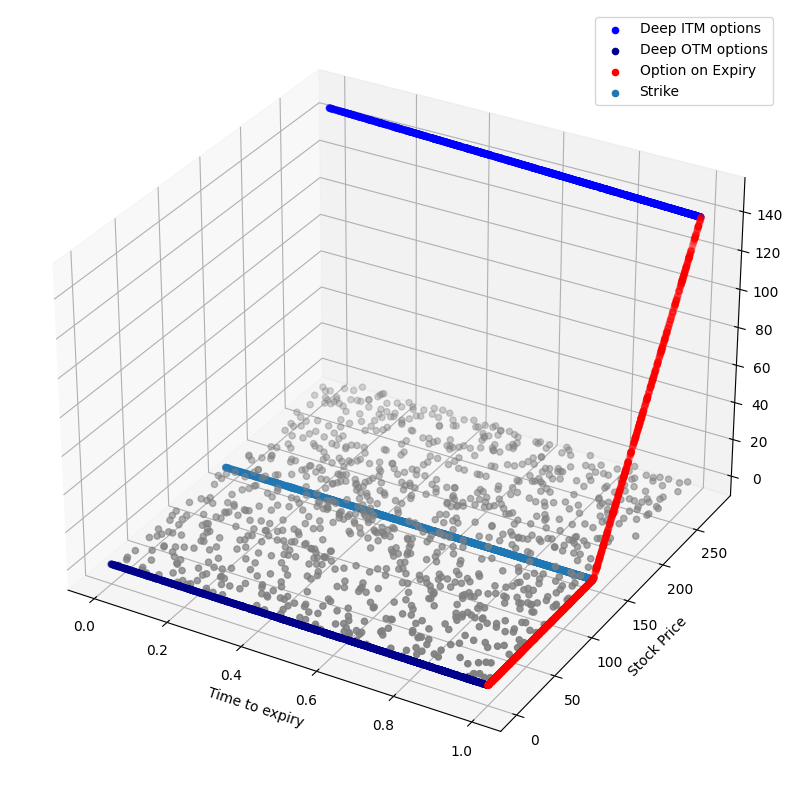

In [34]:
# Expiry data points [Constraint on t]
X_tn,y_tn = EndPoints(1000,K)

# Data points for boundaries on S-> 0 and S-> infinity [Constraints on S]
X_bottom,y_bottom,X_top,y_top = BoundaryPoints(1000, K,r,T)

# PDE Data Points
X_pde,y_pde = PDEPoints(1000)

fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection = "3d")

ax.scatter3D(X_pde[:,0],X_pde[:,1],y_pde,color = 'gray')
ax.scatter3D(X_top[:,0],X_top[:,1],y_top, color = 'blue', label = 'Deep ITM options')
ax.scatter3D(X_bottom[:,0],X_bottom[:,1], y_bottom, color = 'darkblue', label = 'Deep OTM options')
ax.scatter3D(X_tn[:,0],X_tn[:,1], y_tn, color = 'red', label = 'Option on Expiry')
ax.scatter3D(X_top[:,0],K,0, label = "Strike")
plt.ylabel("Stock Price")
plt.xlabel("Time to expiry")
plt.legend()

Neural Network

In [35]:
# Shifted ELU function:
class shiftedELU(nn.Module):
    def __init__(self,alpha = 0.001,K=0):
        super(shiftedELU,self).__init__()
        self.alpha = alpha 
        self.K = K
        self.ELU = nn.ELU(alpha)
    
    def forward(self, x):
        return self.ELU(x-self.K)

In [36]:
class Gated_PINN(nn.Module):
    def __init__(self):
        super(Gated_PINN, self).__init__()
        self.K = K
        
        # Define 9 individual models
        self.models = nn.ModuleList([self.create_single_model() for _ in range(9)])
        
        # Right branch
        self.model_right = nn.Sequential(
            nn.Linear(2, 5),
            nn.Sigmoid(),
            nn.Linear(5, 9),
            nn.Softmax(dim=1)
        )
    
    def create_single_model(self):
        # Left branch of a single model (Softplus)
        left_branch = nn.Sequential(
            nn.Linear(1, 5),
            nn.Softplus()
        )
        
        # Right branch of a single model (Sigmoid)
        right_branch = nn.Sequential(
            nn.Linear(1, 5),
            nn.Sigmoid()
        )
        
        return nn.ModuleDict({
            'left': left_branch,
            'right': right_branch,
            'output': nn.Sequential(
                nn.Linear(5, 1, bias=False)  # Equivalent to use_bias=False in Keras
            )
        })

    def forward(self, x):
        # Process left branch (concatenation of all 9 sub-models)
        # Split the input into (t, spot)
        t = x[:, 0].unsqueeze(1)  # Reshape to (batch_size, 1)
        spot = x[:, 1].unsqueeze(1)  # Reshape to (batch_size, 1)

        # Recombine t and transformed spot
        x = torch.cat((t, spot-self.K), dim=1)

        x_left = x[:,0].view(-1, 1)
        x_right = x[:,1].view(-1, 1)

        left_outputs = []
        for model in self.models:
            left_out = model['left'](x_left)
            right_out = model['right'](x_right)
            merged_out = left_out * right_out  # Element-wise multiplication
            final_out = model['output'](merged_out)
            left_outputs.append(final_out)
        
        # Concatenate the 9 outputs
        left_concatenated = torch.cat(left_outputs, dim=1)
        
        # Process right branch
        right_out = self.model_right(x)
        
        # Dot product of left and right branches
        dot_output = torch.sum(left_concatenated * right_out, dim=1, keepdim=True)
        
        return dot_output

In [615]:
class PINN(nn.Module):
    def __init__(self, input_size, output_size, hidden_size, n_layers, strike=K, sigma = sigma):
        super(PINN,self).__init__()
        self.K = strike
        self.activation1 = nn.Sigmoid()
        self.activation2 = nn.Softplus()

        self.activation3 = nn.ELU(alpha=.01)
        self.activation4 =  nn.Tanh() # best practices // torch.sqrt(sigma)*100*
        self.activation5 = nn.ReLU()


        self.fc_in = nn.Sequential(*[nn.Linear(in_features=input_size,out_features=hidden_size)])
        self.fc_hidden = nn.Sequential(*[nn.Sequential(*[nn.Linear(hidden_size,hidden_size),self.activation4]) for _ in range(n_layers)])
        self.fc_out = nn.Linear(in_features=hidden_size, out_features=output_size)

        self.fc_in2 = nn.Sequential(*[nn.Linear(in_features=input_size,out_features=hidden_size)])
        self.w = nn.Parameter(torch.tensor(1.0, requires_grad=True))

        # Weight constraint for non-negative weights
        self.non_neg_constraint()

    def non_neg_constraint(self):
        for param in self.parameters():
            with torch.no_grad():
                param.clamp_(min=0)  # Ensures non-negative weights

    def forward(self, x):
        # convert input to (t,IV) pair:
        # Split the input into (t, spot)
        t = x[:, 0].unsqueeze(1)  # Reshape to (batch_size, 1)
        spot = x[:, 1].unsqueeze(1)  # Reshape to (batch_size, 1)

        # Recombine t and transformed spot
        transformed_input = torch.cat((t, spot-self.K), dim=1)
        IV = self.activation5(spot-self.K) # Apply shifted ELU to spot only to find Intrinsic value

        # Using Tanh activation for nonlinearity and differentiablity:
        inputs = self.fc_in(transformed_input)
        hidden = inputs

        for layer in self.fc_hidden:
            hidden = layer(hidden)+hidden
        
        # tranform hidden to output:
        output = self.fc_out(hidden) + IV

        return output

Loss Function to Minimize

In [37]:
mseloss = nn.MSELoss()
def pde_loss(outputs, inputs, sigma, r):
    # input = [t,S]
    frist_order = tgrad.grad(inputs = inputs, outputs=outputs.to(device), grad_outputs=torch.ones(outputs.shape).to(device),create_graph=True,retain_graph=True)[0]
    dC_dt = frist_order[:,0].view(-1,1)
    dC_dS = frist_order[:,1].view(-1,1)
    second_order = tgrad.grad(inputs=inputs,outputs=dC_dS.to(device),grad_outputs=torch.ones(dC_dS.shape).to(device),create_graph=True)[0]
    dC2_dS2 = second_order[:,1].view(-1,1)

    S = inputs[:,1].view(-1,1)
    # return PDE loss
    return mseloss(dC_dt + .5*dC2_dS2*pow(sigma*S,2) + r*S*dC_dS, r*outputs)

def boundary_loss(pred, labels):
    return mseloss(pred,labels)

def pinn_loss(pde_loss,boundary_loss):
    return pde_loss + boundary_loss

Training

In [38]:
# Model
# pinn = PINN(input_size=2,output_size=1,hidden_size=128, n_layers=4)
pinn = Gated_PINN()
pinn.to(device)

Gated_PINN(
  (models): ModuleList(
    (0-8): 9 x ModuleDict(
      (left): Sequential(
        (0): Linear(in_features=1, out_features=5, bias=True)
        (1): Softplus(beta=1.0, threshold=20.0)
      )
      (right): Sequential(
        (0): Linear(in_features=1, out_features=5, bias=True)
        (1): Sigmoid()
      )
      (output): Sequential(
        (0): Linear(in_features=5, out_features=1, bias=False)
      )
    )
  )
  (model_right): Sequential(
    (0): Linear(in_features=2, out_features=5, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=5, out_features=9, bias=True)
    (3): Softmax(dim=1)
  )
)

In [40]:
loss_history = []
MSE_losses = [] # t=0 loss, S=infintiy loss, S=0 loss, PDE loss

In [41]:
print('Strike:',K)
print('Sigma:',sigma)
print('R:',r)

Strike: 140
Sigma: 0.18899999999999997
R: 0.0492


Initial training using Adam optimizer

In [43]:
# Define parameters
optimizer = optim.Adam(pinn.parameters(),lr = .0009)
lr_loss_weight = .1
physics_lr = 100
expiry_lr = 20
loss_weight = torch.nn.Parameter(torch.from_numpy(np.array([1,1,1,1])).float()) # weigths of initial loss, boundary loss S= Large, Boundary Loss S = 0, PDE loss
epochs = 3000
start =0

for itr in range(epochs):
    pinn.train()
    i = itr + start
    # generate new random data every iteration and converting to tensors
    X_tn,y_tn = EndPoints(1000,K) # Expiry data points [Constraint on t]
    X_tn = torch.from_numpy(X_tn).float().to(device)
    y_tn = torch.from_numpy(y_tn).float().to(device)

    X_bottom,y_bottom,X_top,y_top = BoundaryPoints(1000, K,r,T) # Data points for boundaries on S-> 0 and S-> infinity [Constraints on S]
    X_bottom = torch.from_numpy(X_bottom).float().to(device)
    y_bottom = torch.from_numpy(y_bottom).float().to(device)
    X_top = torch.from_numpy(X_top).float().to(device)
    y_top = torch.from_numpy(y_top).float().to(device)

    X_pde,_ = PDEPoints(2500) # PDE Data Points
    X_pde = torch.from_numpy(X_pde).float().requires_grad_().to(device)

    # pde loss
    C_pde = pinn(X_pde).to(device)
    pde_losses = physics_lr*pde_loss(C_pde, X_pde, sigma, r)

    # calculating indiviaul constraints loss
    C_tn = pinn(X_tn).to(device)
    tn_losses = expiry_lr*boundary_loss(C_tn,y_tn)
    C_top = pinn(X_top).to(device)
    sN_losses = boundary_loss(C_top,y_top)
    C_bottom = pinn(X_bottom).to(device)
    s0_losses = boundary_loss(C_bottom, y_bottom)

    MSE_losses.append([tn_losses,sN_losses,s0_losses,pde_losses])
    # updating parameters of NN to minimize weighted loss
    optimizer.zero_grad()
    loss = loss_weight[0]*tn_losses +  loss_weight[1]*sN_losses + loss_weight[2]*s0_losses + loss_weight[3]*pde_losses
    loss.backward()
    optimizer.step()

    true_loss = tn_losses +  sN_losses + s0_losses + pde_losses
    loss_history.append(true_loss)
    # IF MSE loss is decreasing, update weigths [Used for fast initial convergence]
    # if(i == 0 or(MSE_losses[i-1][0]>MSE_losses[i][0] and  MSE_losses[i-1][1]> MSE_losses[i][1] and MSE_losses[i-1][2]>MSE_losses[i][2] and MSE_losses[i-1][3]>MSE_losses[i][3])):
    #     # weight gradients are MSE losses: Performing gradient ascent
    #     loss_weight = loss_weight + lr_loss_weight*torch.tensor(MSE_losses[i])

    print(f'Epoch {i+1}/{epochs} : loss: {true_loss} [Expiry {loss_weight[0]} {tn_losses}] [S=Large {loss_weight[1]} {sN_losses}] [S=0 {loss_weight[2]} {s0_losses}] [PDE {loss_weight[3]} {pde_losses}]')
    if(true_loss<.5):
      break

Epoch 1/3000 : loss: 63.43097686767578 [Expiry 1.0 34.22259521484375] [S=Large 1.0 14.551036834716797] [S=0 1.0 0.06344033032655716] [PDE 1.0 14.593900680541992]
Epoch 2/3000 : loss: 170.75575256347656 [Expiry 1.0 87.4820785522461] [S=Large 1.0 61.32099533081055] [S=0 1.0 0.06198916211724281] [PDE 1.0 21.890684127807617]
Epoch 3/3000 : loss: 59.140594482421875 [Expiry 1.0 16.090585708618164] [S=Large 1.0 29.83327293395996] [S=0 1.0 0.06334228068590164] [PDE 1.0 13.153393745422363]
Epoch 4/3000 : loss: 66.72335815429688 [Expiry 1.0 35.82505416870117] [S=Large 1.0 15.871621131896973] [S=0 1.0 0.06294873356819153] [PDE 1.0 14.963730812072754]
Epoch 5/3000 : loss: 113.77450561523438 [Expiry 1.0 80.11824035644531] [S=Large 1.0 15.234981536865234] [S=0 1.0 0.063673235476017] [PDE 1.0 18.357608795166016]
Epoch 6/3000 : loss: 80.921142578125 [Expiry 1.0 48.54254150390625] [S=Large 1.0 13.383157730102539] [S=0 1.0 0.06318726390600204] [PDE 1.0 18.9322566986084]
Epoch 7/3000 : loss: 51.230403900

Plotting Loss

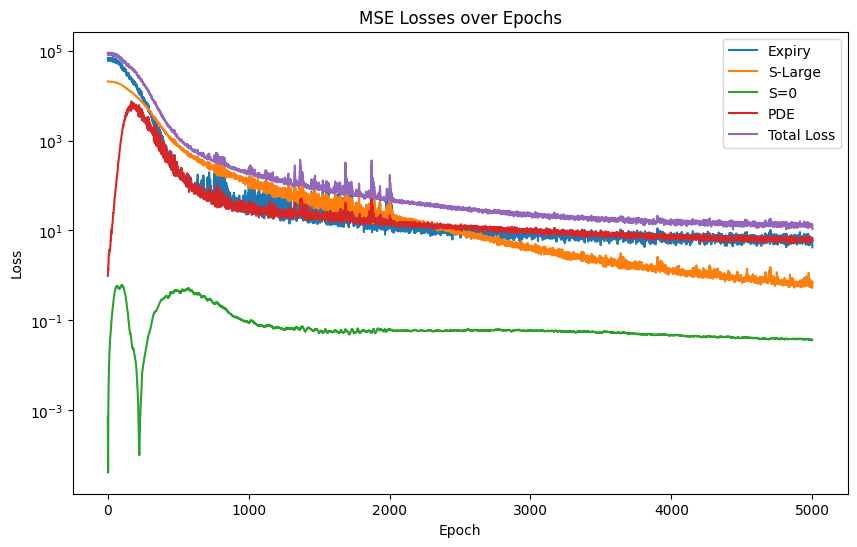

In [48]:
# Convert MSE_losses to separate lists for each loss type
expiry_losses = [loss[0].detach().cpu().numpy() for loss in MSE_losses]
s_large_losses = [loss[1].detach().cpu().numpy() for loss in MSE_losses]
s_zero_losses = [loss[2].detach().cpu().numpy() for loss in MSE_losses]
pde_losses = [loss[3].detach().cpu().numpy() for loss in MSE_losses]

# Convert loss_history to numpy
total_loss = [loss.detach().cpu().numpy() for loss in loss_history]

# Create an array of epochs (1 to epochs)
epochs = np.arange(1, len(MSE_losses) + 1)

# Plot each loss component
plt.figure(figsize=(10,6))
plt.plot(epochs, expiry_losses, label="Expiry")
plt.plot(epochs, s_large_losses, label="S-Large")
plt.plot(epochs, s_zero_losses, label="S=0")
plt.plot(epochs, pde_losses, label="PDE")
plt.plot(epochs, total_loss, label="Total Loss")

# Add labels, title, and legend
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('MSE Losses over Epochs')
plt.legend()
plt.yscale('log')
# Show the plot
plt.show()

Analysis of pricing across time frame

In [18]:
def time_frame_analysis(time_frame):
    spots = np.linspace(K-140,K+140,100)
    # spots = np.linspace(S_range[0],S_range[1],100)
    t = np.array([time_frame]*spots.shape[0])

    # Calculate Pinn output
    X_test = torch.tensor(np.concatenate((t.reshape(-1,1),spots.reshape(-1,1)),axis=1)).float().to(device)
    with torch.no_grad():
        pinn.eval()
        y_pinn = pinn(X_test)

    # calculate output for BSM
    y_bsm = BSM_pricing(X_test[:,1],T-X_test[:,0],torch.tensor(K),torch.tensor(r),torch.tensor(sigma))
    plt.plot(spots,y_bsm.detach().cpu().numpy(),label = "BSM-pricing")
    plt.scatter(spots,y_pinn.detach().cpu().numpy(), s = 2, label = "PINN-pricing",color = "Red", marker='x')
    plt.title(f"Analysis of solution at t={time_frame}")

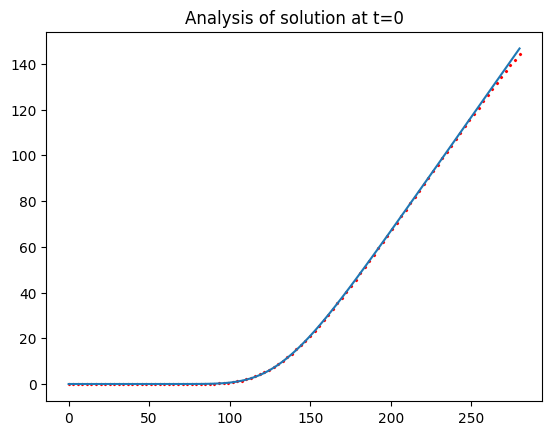

In [44]:
time_frame_analysis(0)

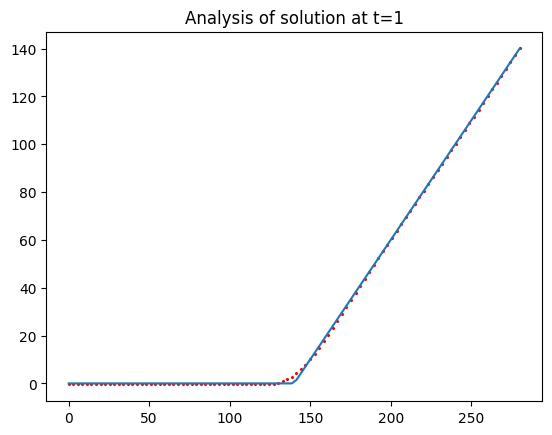

In [45]:
time_frame_analysis(1)

Analysis of PINNs vs BSM surface

In [46]:
s = np.linspace(0,S_range[1],1000)
t = np.linspace(0,T_range[1],1000)
s_grid, t_grid = np.meshgrid(s,t)


X_test = torch.Tensor(np.concatenate((t_grid.flatten().reshape(-1,1),s_grid.flatten().reshape(-1,1)),axis = 1)).float().to(device)
y_bsm_surface = BSM_pricing(X_test[:,1],X_test[:,0],torch.tensor(K),torch.tensor(r), torch.tensor(sigma))
with torch.no_grad():
    pinn.eval()
    y_pinn_surface = pinn(X_test)

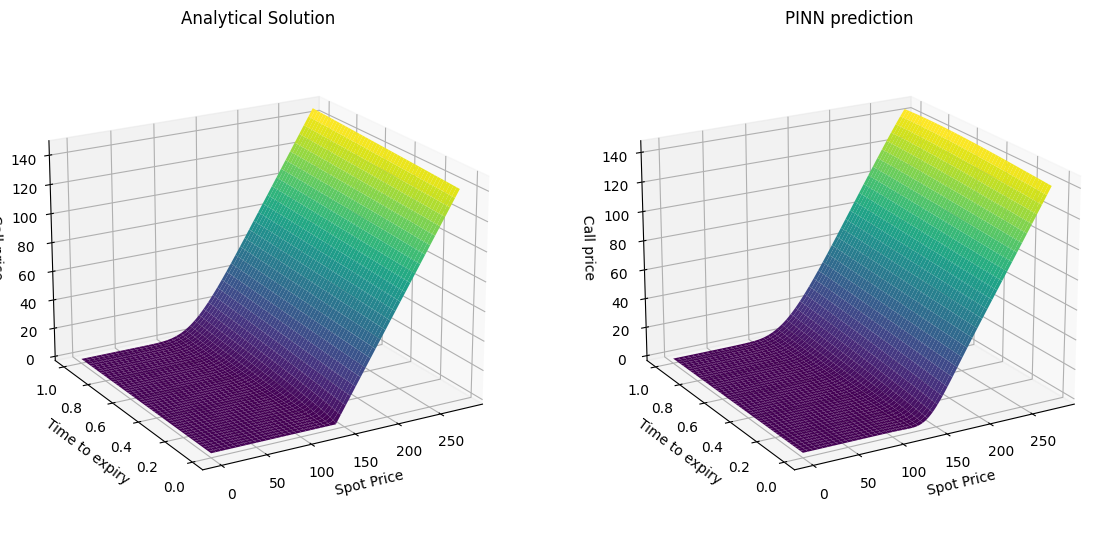

In [47]:
# Error:
print("MSE: ", mseloss(y_bsm_surface,y_pinn_surface))

# Create the 3D plot
fig = plt.figure(figsize=(14,7))
ax = fig.add_subplot(121, projection='3d')
ax.plot_surface(s_grid, t_grid, y_bsm_surface.detach().cpu().numpy().reshape(s_grid.shape), cmap = "viridis")
ax.set_title("Analytical Solution")
ax.set_xlabel("Spot Price")
ax.set_ylabel("Time to expiry")
ax.set_zlabel("Call price")
ax.view_init(elev=20, azim=-120)


# Reverse the time grid for the PINN to mirror BSM's time
t_grid_pinn = 1 - t_grid
ax = fig.add_subplot(122, projection='3d')
ax.plot_surface(s_grid, t_grid_pinn, y_pinn_surface.detach().cpu().numpy().reshape(s_grid.shape), cmap = "viridis")
ax.set_title("PINN prediction")
ax.set_xlabel("Spot Price")
ax.set_ylabel("Time to expiry")
ax.set_zlabel("Call price")
ax.view_init(elev=20, azim=-120)
